# 프로젝트, 다른 시계열 데이터에서 이상치

## data download

https://finance.yahoo.com/quote/NQ%3DF/history?period1=1508976000&period2=1603670400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
- 나스닥 5년치 데이터


In [2]:
## library import

import requests
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.stats.weightstats import ztest

from statsmodels.tsa.seasonal import seasonal_decompose

# 표준정규화
from sklearn.preprocessing import StandardScaler # w

from sklearn.cluster import KMeans # kmeans

from sklearn.cluster import DBSCAN # dbscan

#auto -encoder 
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import copy

In [8]:
## csv file< 통계 data import

csv_file = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E20-Anomaly_Detection/nasdaq/NQ_5y.csv'
#나스닥 5년치 데이터


df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-26,4614.00,4630.00,4592.75,4616.25,4616.25,184127.0
1,2015-10-27,4619.75,4651.75,4601.25,4632.25,4632.25,217939.0


In [9]:
## 날짜 전처리

# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         223
High         223
Low          223
Close        223
Adj Close    223
Volume       223
dtype: int64

In [10]:
# 결측치 숙청

In [11]:
## 결측치 숙청
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 1520
삭제 후 데이터 길이(일자수): 1297


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 기본 통계분석으로 이상치 찾기

- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기
  
</br></br>

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

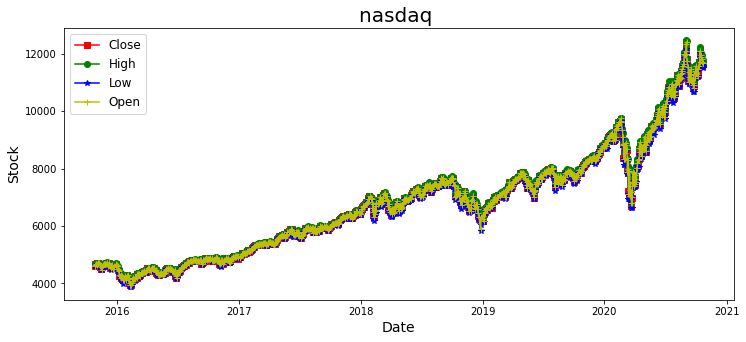

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('nasdaq ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [14]:
# 하한가가 상한가 보다 높은 경우 서칭
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


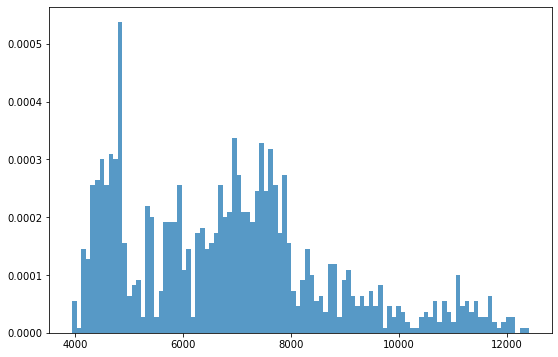

In [17]:

## 주식데이터 분포 확인 - 종가
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [19]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

## p값이.. 0.5에 가깝지 않음.

0.0


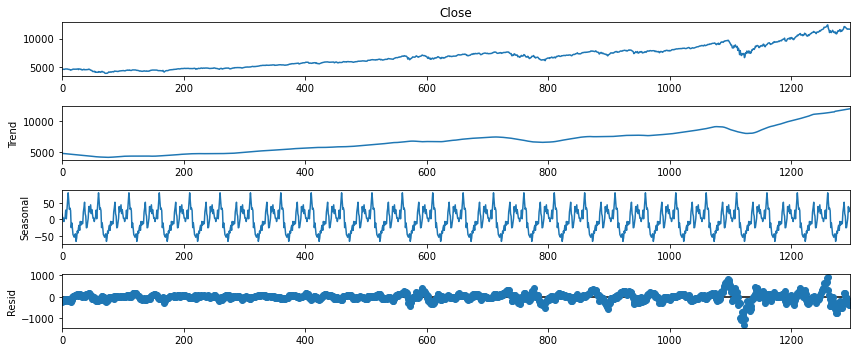

In [20]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

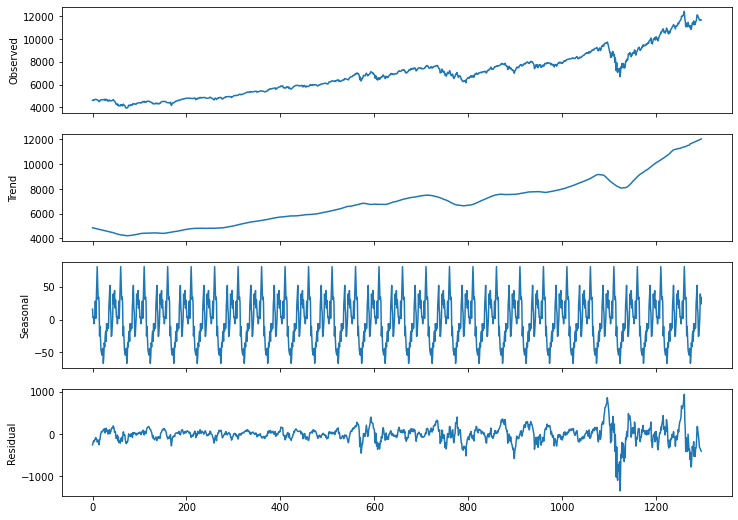

In [21]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

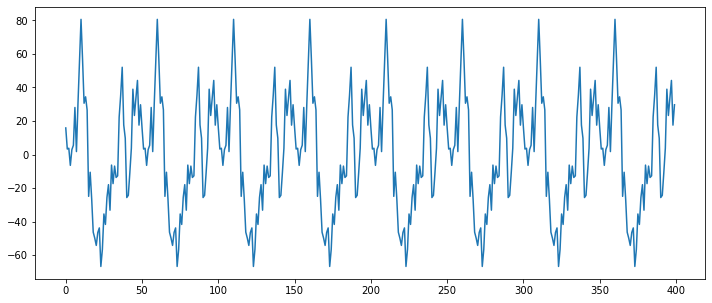

In [23]:
# seasonal 성분
result.seasonal[:400].plot()
#-60 ~ 80 사이를 반복, 

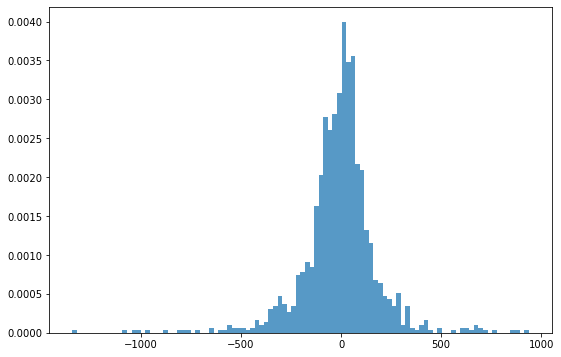

In [24]:
# residual graph
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [25]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-1.4098244036881458 0.15859153887938626


In [26]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -7.38046106277201 표준편차: 188.53346856680608
이상치 갯수: 30


In [27]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

898    2019-06-03
1091   2020-02-12
1092   2020-02-13
1093   2020-02-14
1094   2020-02-16
1095   2020-02-18
1096   2020-02-19
1097   2020-02-20
1098   2020-02-21
1099   2020-02-23
1115   2020-03-12
1117   2020-03-15
1118   2020-03-16
1119   2020-03-17
1120   2020-03-18
1121   2020-03-19
1122   2020-03-20
1123   2020-03-22
1124   2020-03-23
1132   2020-04-01
1254   2020-08-26
1255   2020-08-27
1256   2020-08-28
1257   2020-08-30
1258   2020-08-31
1259   2020-09-01
1260   2020-09-02
1272   2020-09-21
1274   2020-09-23
1275   2020-09-24
Name: Date, dtype: datetime64[ns]

In [ ]:
# 2019년 06월 03일 은 미국에서 대기업(구글 페이스북 삼성등) 대상으로  반독점 위반에 대한 조사실시한다고
# 법무부에서 밝히면서 전체적으로 시장이 하양곡선을 그렸다고 한다.

#2020 02 ~ 04 코로나로 인한 시장수축

# 2020 0826~09월초 이례적인 현상으로 2000년대 들어와서 가장 높은 상승세였다고 한다. 


## Unsupervised Clustering 으로 이상치 찾기
- k-means로 분석하기
- DBSCAN으로 분석하기

<br/><br/>

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

In [28]:
# Open, High, Low, Close, Volume 5가지 데이터를 모두 사
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        # decompose
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()
    
    

,Open,High,Low,Close,Volume
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,6860.255452,6920.896462,6799.323494,6867.561581,378476.987132
std,1882.784560,1913.246165,1854.760281,1888.082320,145762.107657
min,4211.705000,4258.927500,4157.385000,4212.715000,161104.250000
25%,5216.730000,5238.242500,5200.600000,5226.770000,242363.560000
50%,6762.367500,6831.940000,6684.952500,6763.982500,354999.050000
75%,7770.590000,7841.375000,7699.820000,7778.212500,485379.110000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [29]:
rdf.describe()

,Open,High,Low,Close,Volume
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,-7.727758,-7.875836,-7.228208,-7.509210,740.752395
std,194.268505,175.720468,201.382235,188.794188,145134.470494
min,-1236.462845,-1446.140959,-1182.554432,-1342.690140,-562405.934137
25%,-81.280468,-80.235862,-82.794433,-83.570864,-76159.830407
50%,4.538409,2.046312,4.451256,3.863576,-13124.882127
75%,74.026189,69.024702,77.134731,76.049340,64757.215863
max,933.192122,891.127879,906.997510,936.371137,780092.982457


In [30]:
## volume data 가 크기 때문에 정규화거쳐서 조정..

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -7.72775841  -7.8758359   -7.22820843  -7.50920967 740.75239496]


array([[-1.36550803, -1.53322847, -1.1824837 , -1.2884426 , -0.09602761],
       [-1.26597601, -1.31359337, -1.13605165, -1.0887404 , -0.08157213],
       [-1.06077728, -1.05124137, -1.03371984, -0.82310222,  0.52432087],
       ...,
       [-1.73511911, -2.25084606, -1.40640085, -1.86867958,  0.7878256 ],
       [-1.86527304, -2.57283859, -1.91320401, -2.0958553 ,  0.61470438],
       [-2.01028432, -2.97612953, -1.79373282, -2.16813033,  0.7098224 ]])

In [31]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[0 0 0 ... 0 0 0]


In [32]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[445 852]


In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:82',
 'group:1-count:156',
 'group:2-count:37',
 'group:3-count:44',
 'group:4-count:49',
 'group:5-count:197',
 'group:6-count:213',
 'group:7-count:16',
 'group:8-count:37',
 'group:9-count:20',
 'group:10-count:292',
 'group:11-count:83',
 'group:12-count:7',
 'group:13-count:15',
 'group:14-count:49']

In [38]:
# 10이하의 특이분류
df[kmeans.labels_==12]

,Date,Open,High,Low,Close,Adj Close,Volume
1117,2020-03-15,7100.00,7978.00,6942.50,7215.25,7215.25,578813.0
1118,2020-03-16,7903.00,7905.25,6927.00,7057.50,7057.50,307368.0
1119,2020-03-17,7053.00,7552.25,6948.75,7405.25,7405.25,317501.0
1120,2020-03-18,7386.00,7392.25,6830.00,7225.25,7225.25,156283.0
1121,2020-03-19,7251.75,7521.50,6894.25,7293.50,7293.50,115519.0
1123,2020-03-22,6798.00,6798.00,6628.75,6688.75,6688.75,321230.0
1124,2020-03-23,6798.00,7316.25,6628.75,6984.50,6984.50,633237.0


In [36]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1.297000e+03
mean,6852.448768,6912.961072,6792.011835,6859.981597,6859.981597,3.792036e+05
std,1889.877153,1916.983392,1864.355252,1894.189815,1894.189815,2.138222e+05
min,3954.500000,3985.500000,3862.500000,3944.250000,3944.250000,0.000000e+00
25%,5211.250000,5232.500000,5209.750000,5226.750000,5226.750000,2.216740e+05
50%,6819.500000,6901.250000,6744.750000,6824.500000,6824.500000,3.432730e+05
75%,7818.500000,7879.500000,7740.000000,7820.250000,7820.250000,4.876380e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [42]:
# 2004-03-15 주변 정황
df.iloc[1111:1130]

,Date,Open,High,Low,Close,Adj Close,Volume
1111,2020-03-08,8677.00,8726.50,8310.50,8648.75000,8648.75000,1086560.0
1112,2020-03-09,8369.00,8375.00,7820.00,7951.50000,7951.50000,560913.0
1113,2020-03-10,7893.75,8378.75,7814.25,8331.50000,8331.50000,982070.0
1114,2020-03-11,8317.00,8334.25,7892.75,8003.50000,8003.50000,990236.0
1115,2020-03-12,7998.75,8108.00,7128.50,7215.25000,7215.25000,876291.0
1116,2020-03-13,7100.00,7978.00,6942.50,7915.75000,7915.75000,584274.0
1117,2020-03-15,7100.00,7978.00,6942.50,7215.25000,7215.25000,578813.0
1118,2020-03-16,7903.00,7905.25,6927.00,7057.50000,7057.50000,307368.0
1119,2020-03-17,7053.00,7552.25,6948.75,7405.25000,7405.25000,317501.0
1120,2020-03-18,7386.00,7392.25,6830.00,7225.25000,7225.25000,156283.0


In [43]:
### 코로나 확산 시기

In [41]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.335285,-0.347308,-0.198157,-0.235036,-1.223249
1,0.416232,0.414273,0.364126,0.356126,0.347206
2,-1.706424,-1.900592,-1.811528,-1.826279,1.267147
3,-0.682036,-0.786036,-1.089484,-1.095898,2.117294
4,1.314567,1.342500,1.452908,1.444833,-1.250364
5,-0.586299,-0.594379,-0.541722,-0.549703,0.197152
6,0.463754,0.480656,0.565412,0.554190,-0.644485
7,-3.238055,-3.067596,-3.191196,-2.901506,-0.025890
8,-1.550014,-1.516008,-1.386519,-1.322369,-0.805476
9,3.477551,3.526783,3.488549,3.468480,-0.134458


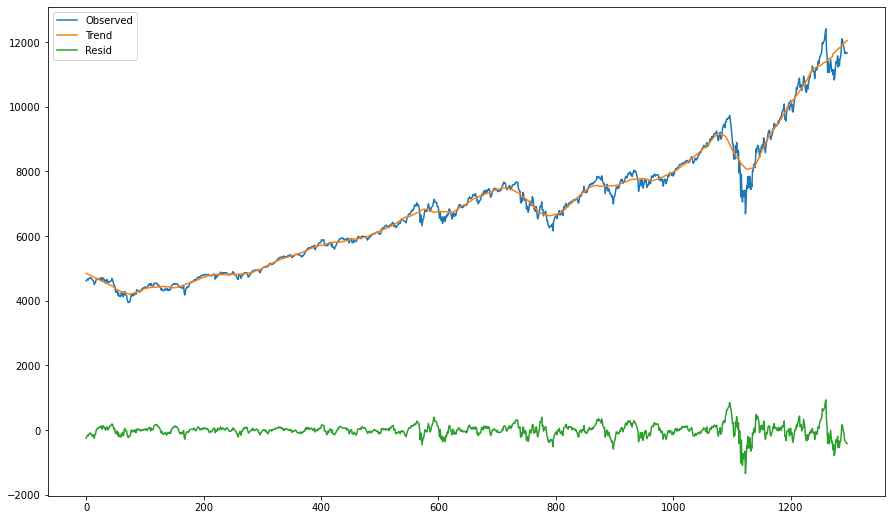

In [44]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show() 




In [45]:
## dbscan

clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [46]:
print(clustering.labels_)

[0 0 0 ... 0 0 0]


In [47]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:90',
 'group:0-count:1194',
 'group:1-count:2',
 'group:2-count:4',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:3']

0

## LSTM 오토인코더로 이상치 찾기
- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기


In [51]:
# <난수 설정
tf.random.set_seed(777)
np.random.seed(777)

In [52]:
# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [53]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [54]:
### model define
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [56]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E20-Anomaly_Detection/nasdq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [57]:
# model fit 
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
40/41 [============================>.] - ETA: 0s - loss: 1.5081 - mae: 1.5081
Epoch 00001: val_loss improved from inf to 1.44343, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E20-Anomaly_Detection/nasdq/mymodel.ckpt
41/41 [==============================] - 1s 36ms/step - loss: 1.4896 - mae: 1.4896 - val_loss: 1.4434 - val_mae: 1.4434
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.8588 - mae: 0.8588
Epoch 00002: val_loss improved from 1.44343 to 1.00539, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E20-Anomaly_Detection/nasdq/mymodel.ckpt
41/41 [==============================] - 1s 30ms/step - loss: 0.8588 - mae: 0.8588 - val_loss: 1.0054 - val_mae: 1.0054
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.7054 - mae: 0.7054
Epoch 00003: val_loss improved from 1.00539 to 0.44382, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E20-Anomaly_Detection/nasdq/mymodel.c

In [58]:
model.load_weights(checkpoint_path)

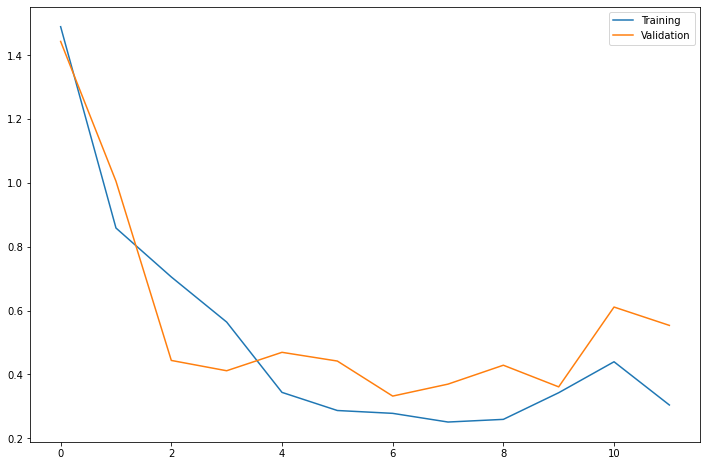

In [59]:
## 학습 과정 그래프
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

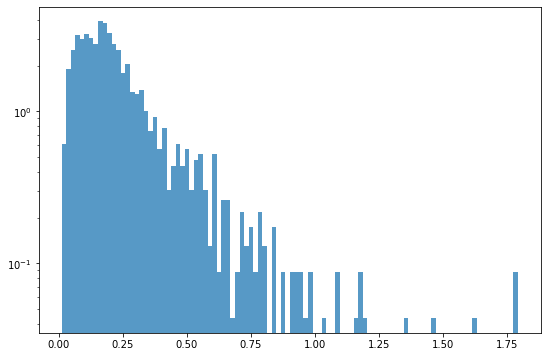

In [60]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

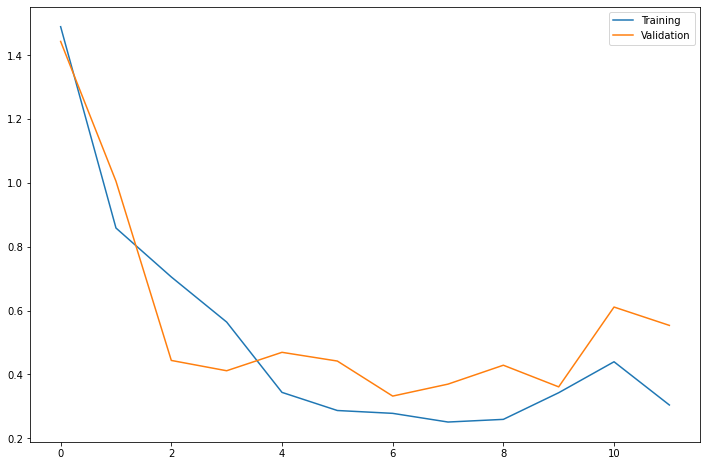

In [61]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

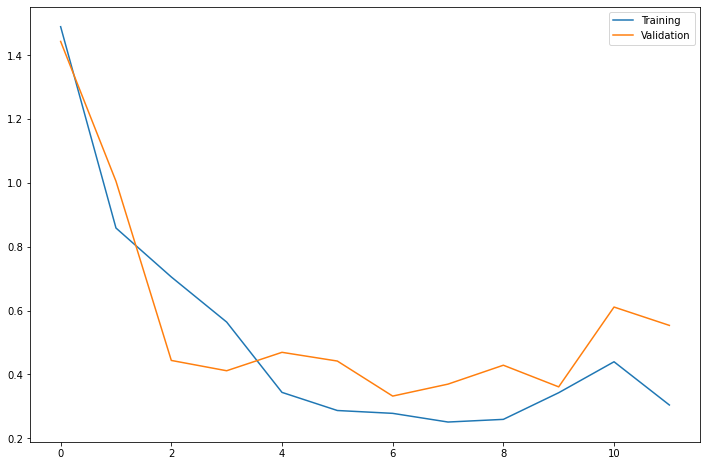

In [62]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

In [64]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss


In [65]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
32,2015-12-24,4607.750000,4630.000000,4600.750000,4611.000000,4611.000000,62054.0,0.308629
35,2015-12-30,4687.250000,4695.000000,4643.500000,4646.000000,4646.000000,117427.0,0.307151
37,2016-01-04,4592.500000,4606.750000,4429.750000,4504.500000,4504.500000,368671.0,0.317585
40,2016-01-07,4450.250000,4458.500000,4283.000000,4289.250000,4289.250000,501315.0,0.406794
41,2016-01-08,4298.000000,4370.000000,4255.750000,4261.500000,4261.500000,480513.0,0.391678
...,...,...,...,...,...,...,...,...
1271,2020-10-02,11566.799805,11604.799805,11204.500000,11233.200195,11233.200195,806629.0,0.379761
1276,2020-10-09,11562.000000,11739.000000,11552.500000,11724.799805,11724.799805,408445.0,0.367935
1277,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,0.543708
1278,2020-10-13,12100.000000,12249.000000,12019.000000,12094.000000,12094.000000,754735.0,0.599434


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


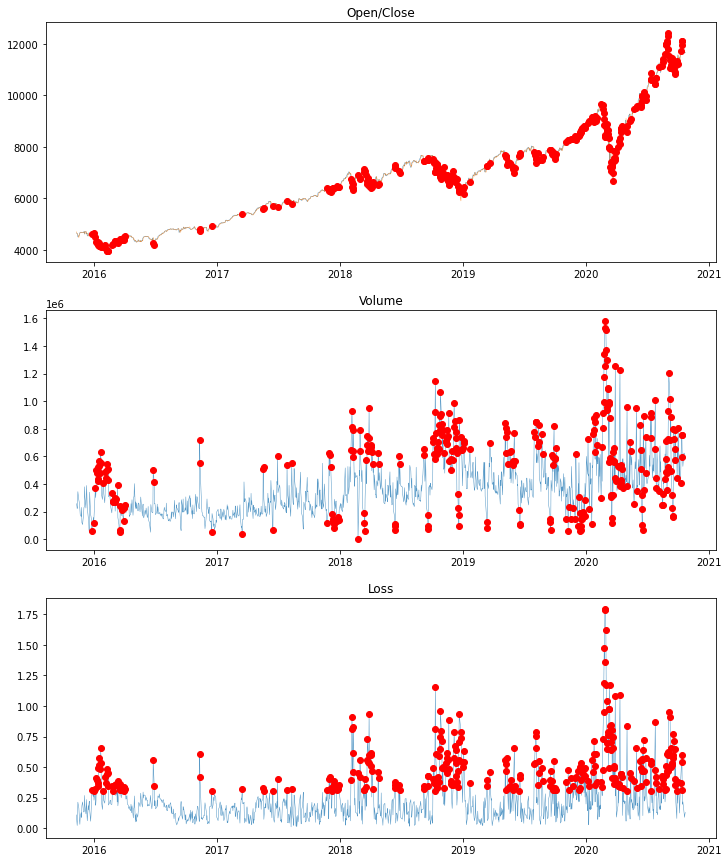

In [66]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])